# Model hyperparameter tuning with scVI

```{warning}
`scvi.autotune` development is still in progress. The API is subject to change.
```

Finding an effective set of model hyperparameters (e.g. learning rate, number of hidden layers, etc.) is an important component in training a model as its performance can be highly dependent on these non-trainable parameters. Manually tuning a model often involves picking a set of hyperparameters to search over and then evaluating different configurations over a validation set for a desired metric. This process can be time consuming and can require some prior intuition about a model and dataset pair, which is not always feasible.

In this tutorial, we show how to use `scvi`'s [`autotune`](https://docs.scvi-tools.org/en/latest/api/user.html#model-hyperparameter-autotuning) module, which allows us to automatically find a good set of model hyperparameters using [Ray Tune](https://docs.ray.io/en/latest/tune/index.html). We will use `SCVI` and a subsample of the [heart cell atlas](https://www.heartcellatlas.org/#DataSources) for the task of batch correction, but the principles outlined here can be applied to any model and dataset. In particular, we will go through the following steps:

1. Installing required packages
1. Loading and preprocessing the dataset
1. Defining the tuner and discovering hyperparameters
1. Running the tuner
1. Comparing latent spaces
1. Optional: Monitoring progress with Tensorboard
1. Optional: Tuning over integration metrics with `scib-metrics`

## Installing required packages

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/access/miniconda3/lib/python3.12/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import tempfile

import ray
import scanpy as sc
import scvi
import seaborn as sns
import torch
from ray import tune
from scvi import autotune
import os
os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["TUNE_DISABLE_STRICT_METRIC_CHECKING"] = "1"
import jax

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.2.2


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()
scvi.settings.logging_dir = save_dir.name

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Loading and preprocessing the dataset

In [5]:
adata = scvi.data.heart_cell_atlas_subsampled(save_path=save_dir.name)
adata.layers["counts"] = adata.X.copy()  # preserve counts
adata

INFO     Downloading file at /tmp/tmpv690v5hw/hca_subsampled_20k.h5ad                                              


Downloading...:   0%|          | 0/65714.0 [00:00<?, ?it/s]

AnnData object with n_obs × n_vars = 18641 × 26662
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts'
    uns: 'cell_type_colors'
    layers: 'counts'

The only preprocessing step we will perform in this case will be to subsample the dataset for 2000 highly variable genes using `scanpy` for faster model training.

In [6]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat_v3", subset=True)
adata

AnnData object with n_obs × n_vars = 18641 × 2000
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_type_colors', 'hvg'
    layers: 'counts'

## Defining the tuner and discovering hyperparameters

The first part of our workflow is the same as the standard `scvi-tools` workflow: we start with our desired model class, and we register our dataset with it using `setup_anndata`. All datasets must be registered prior to hyperparameter tuning.

In [9]:
model_cls = scvi.model.SCVI
model_cls.setup_anndata(adata,layer="counts",labels_key="cell_type",batch_key="cell_source")

Our main entry point to the `autotune` module is the `ModelTuner` class, a wrapper around [`ray.tune.Tuner`](https://docs.ray.io/en/latest/tune/api_docs/execution.html#tuner) with additional functionality specific to `scvi-tools`. We can define a new `ModelTuner` by providing it with our model class.

`ModelTuner` will register all tunable hyperparameters in `SCVI` and all of them are accessible to tune starting version 1.2.0.

## Running the tuner

Now that we know what hyperparameters are available to us, we can define a search space using the [search space API](https://docs.ray.io/en/latest/tune/api/search_space.html) in `ray.tune`. For this tutorial, we choose a simple search space with two model hyperparameters and one training plan hyperparameter. These can all be combined into a single dictionary that we pass into the `fit` method.

In [10]:
search_space = {
    "model_params": {"n_hidden": tune.choice([64, 128, 256]), "n_layers": tune.choice([1, 2, 3])},
    "train_params": {"max_epochs": 100, "plan_kwargs": {"lr": tune.loguniform(1e-4, 1e-2)}},
}

There are a couple more arguments we should be aware of before fitting the tuner:

- `num_samples`: The total number of hyperparameter sets to sample from ``. This is the total number of models that will be trained.

  For example, if we set `num_samples=2`, based on the above search space, we might sample two models with the following hyperparameter configurations:

  ```python
  model1 = {
      "n_hidden": 64,
      "n_layers": 1,
      "lr": 0.001,
  }
  model2 = {
      "n_hidden": 64,
      "n_layers": 3,
      "lr": 0.0001,
  }
  ```

- `max_epochs`: The maximum number of epochs to train each model for.

  Note: This does not mean that each model will be trained for `max_epochs`. Depending on the scheduler used, some trials are likely to be stopped early.

- `resources`: A dictionary of maximum resources to allocate for the whole experiment. This allows us to run concurrent trials on limited hardware.

Now, we can call `fit` on the tuner to start the hyperparameter sweep. This will return a `TuneAnalysis` dataclass, which will contain the best set of hyperparameters, as well as other information.

In [11]:
ray.init(log_to_driver=False)

2025-02-16 17:21:44,597	INFO worker.py:1832 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8267 


Python version:,3.12.7
Ray version:,2.42.1
Dashboard:,http://127.0.0.1:8267


In [12]:
results = autotune.run_autotune(
    model_cls,
    data=adata,
    mode="min",
    metrics="validation_loss",
    search_space=search_space,
    num_samples=5,
    resources={"cpu": 10, "gpu": 1},
)

2025-02-16 17:24:37,752	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/tmp/tmpv690v5hw/scvi_18d70fdd-bf19-4348-92c7-251479b6153d/scvi_18d70fdd-bf19-4348-92c7-251479b6153d' in 0.0029s.
2025-02-16 17:24:37,755	INFO tune.py:1041 -- Total run time: 172.59 seconds (172.18 seconds for the tuning loop).


In [13]:
print(results.result_grid)

ResultGrid<[
  Result(
    metrics={'validation_loss': 468.38323974609375},
    path='/tmp/tmpv690v5hw/scvi_18d70fdd-bf19-4348-92c7-251479b6153d/scvi_18d70fdd-bf19-4348-92c7-251479b6153d/_trainable_92f2cbb7_1_n_hidden=128,n_layers=1,max_epochs=100,lr=0.0006_2025-02-16_17-21-45',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'validation_loss': 468.3775634765625},
    path='/tmp/tmpv690v5hw/scvi_18d70fdd-bf19-4348-92c7-251479b6153d/scvi_18d70fdd-bf19-4348-92c7-251479b6153d/_trainable_c6809c70_2_n_hidden=256,n_layers=3,max_epochs=100,lr=0.0025_2025-02-16_17-21-53',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'validation_loss': 572.58056640625},
    path='/tmp/tmpv690v5hw/scvi_18d70fdd-bf19-4348-92c7-251479b6153d/scvi_18d70fdd-bf19-4348-92c7-251479b6153d/_trainable_925d2317_3_n_hidden=128,n_layers=2,max_epochs=100,lr=0.0015_2025-02-16_17-22-01',
    filesystem='local',
    checkpoint=None
  ),
  Result(
    metrics={'validation_loss': 7

## Comparing latent spaces

Work in progress: please check back in the next release!

## Optional: Monitoring progress with Tensorboard

Ray by default plots the metrics and results into tensorboard. It can be accessed usually under http://localhost:6006/ once the optimization is done

## Optional: Tuning over integration metrics with `scib-metrics`

Starting SCVI-Tools v1.3 we are now able to hyperparameter tune for optimal scib-metrics of any choice. 
This is currently works only for SCVI and SCANVI models. 
Note that youll need to update for the recent scib-metrics jax based package.

The idea in performing this is very much the same as before, we just need to select a metric that can be optimize from the pool of metrics that scib-metrics holds as seen in the following list:
"Silhouette label",
"Silhouette batch",
"Isolated labels",
"Leiden NMI",
"Leiden ARI",
"KMeans NMI",
"KMeans ARI",
"cLISI",
"iLISI",
"KBET",
"Graph connectivity",
"PCR comparison",
"Batch correction",
"Bio conservation",
"Total"
The last 3 are the aggegative metrics that are average of the relevant group.

Those metrics are the columns names of the output result table of scib metrics. For all metrics, higher means better and range [0..1]. For more information about those metrics see the [scib-metric docs](https://scib-metrics.readthedocs.io/en/stable/)

Note that usually in order to compare bio conservation metrics we need to apply a semi supervised model.
Also note that in order to save run time we select a random number of cells to calculate the scib metrics. The default is 100 but it can be changed with the parameter scib_subsample_rows, like in the following example:
Here we apply the hyper parameter tuning for the same model in the previous example, while optimizing for iLISI (a batch correction metric, see [here](https://scib.readthedocs.io/en/latest/api/scib.metrics.ilisi_graph.html))

In [14]:
search_space_scib = {
    "model_params": {"n_hidden": tune.choice([64, 128, 256]), "n_layers": tune.choice([1, 2, 3])},
    "train_params": {"max_epochs": 10, "plan_kwargs": {"lr": tune.loguniform(1e-4, 1e-2)}},
}

In [15]:
results_scib = autotune.run_autotune(
    model_cls,
    data=adata,
    metrics="iLISI",
    mode="max",
    search_space=search_space_scib,
    num_samples=2,
    seed=0,
    scheduler="asha",
    searcher="hyperopt",
    resources={"cpu": 20, "gpu": 0},
    scib_subsample_rows=1000
)

2025-02-16 17:27:16,493	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/tmp/tmpv690v5hw/scvi_4d3486ef-20ea-473c-9211-8c821f60f7c5/scvi_4d3486ef-20ea-473c-9211-8c821f60f7c5' in 0.0024s.
2025-02-16 17:27:16,495	INFO tune.py:1041 -- Total run time: 158.67 seconds (158.66 seconds for the tuning loop).


The first run ended with a higher iLISI score. We can visualize the different UMAPs to see that indeed the 1st choice gives a better integration for cell source than the other:

In [16]:
model1 = scvi.model.SCVI(adata,n_hidden=128,n_layers=1)
model1.train(max_epochs=10,plan_kwargs = {"lr": 0.0005})
adata.obsm["X_scVI1"] = model1.get_latent_representation()

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/access/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


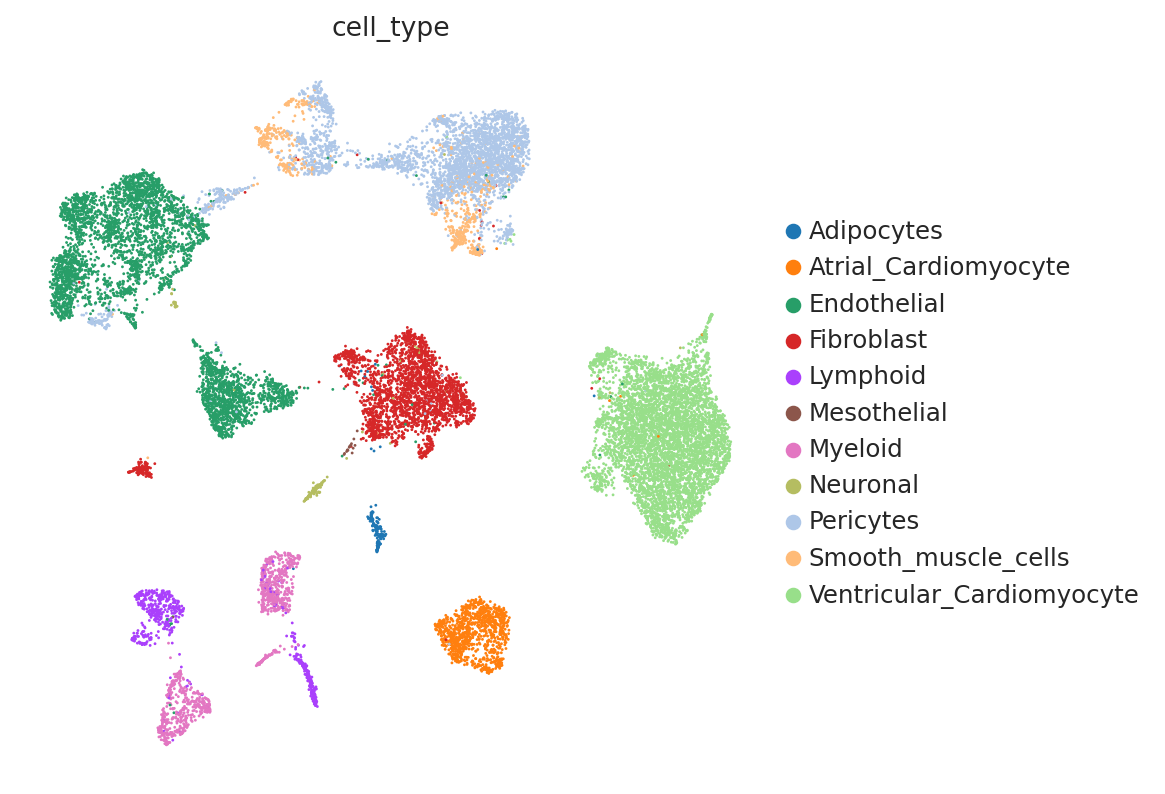

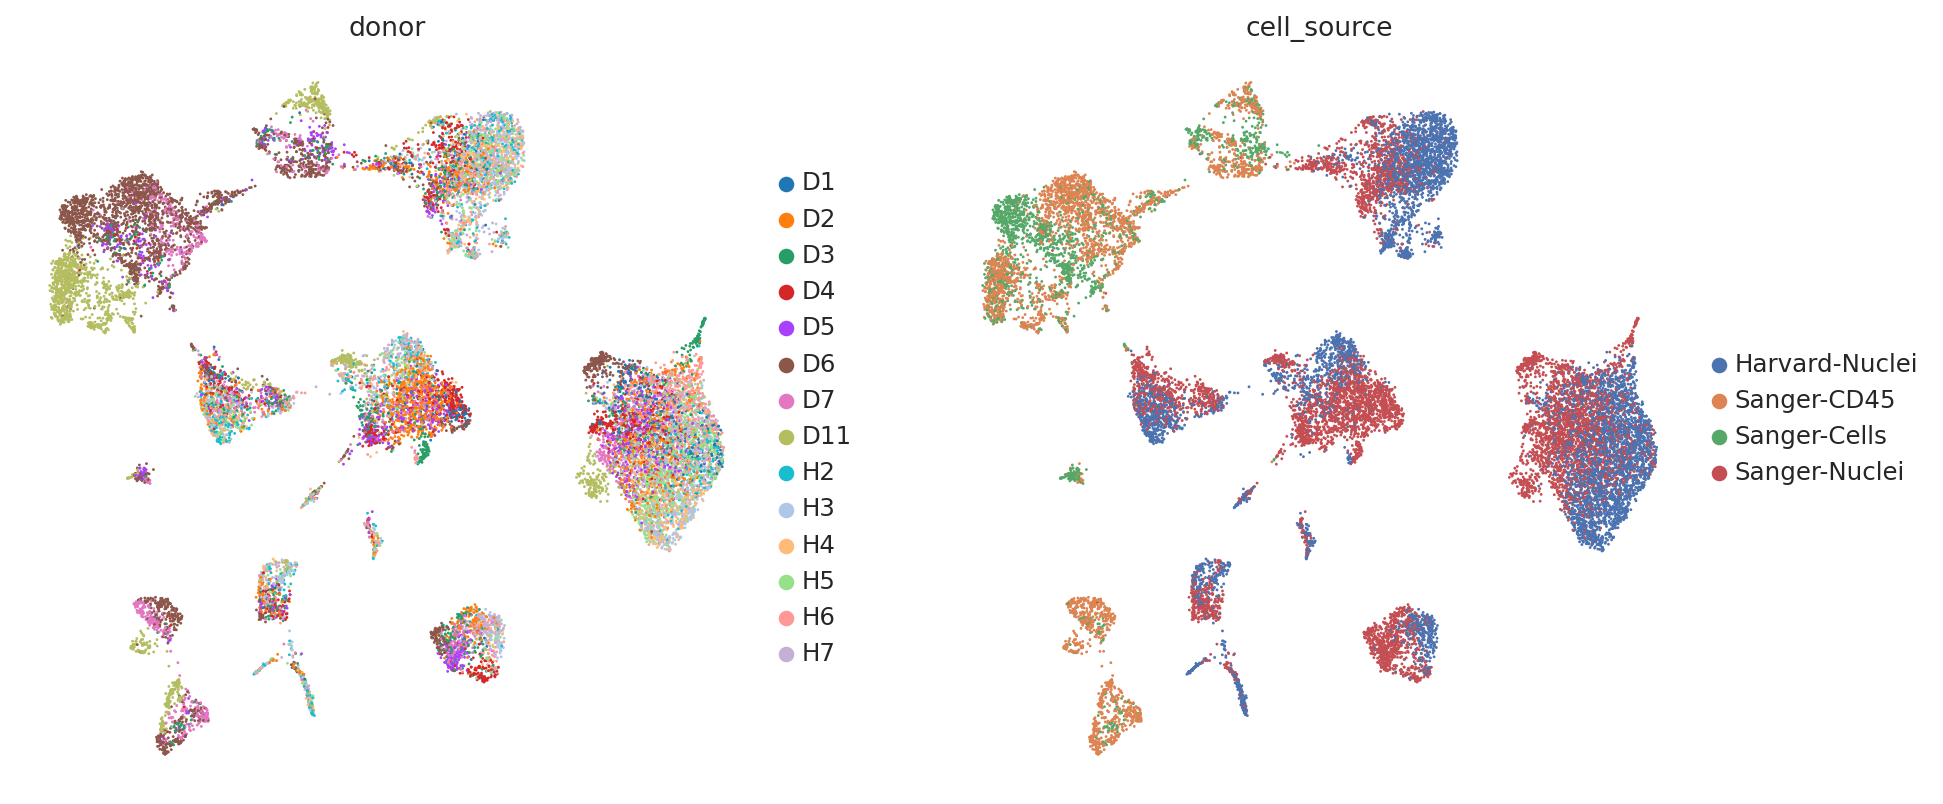

In [17]:
sc.pp.neighbors(adata, use_rep="X_scVI1")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

In [18]:
model2 = scvi.model.SCVI(adata,n_hidden=256,n_layers=3)
model2.train(max_epochs=10,plan_kwargs = {"lr": 0.0025})
adata.obsm["X_scVI2"] = model2.get_latent_representation()

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/access/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/10 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


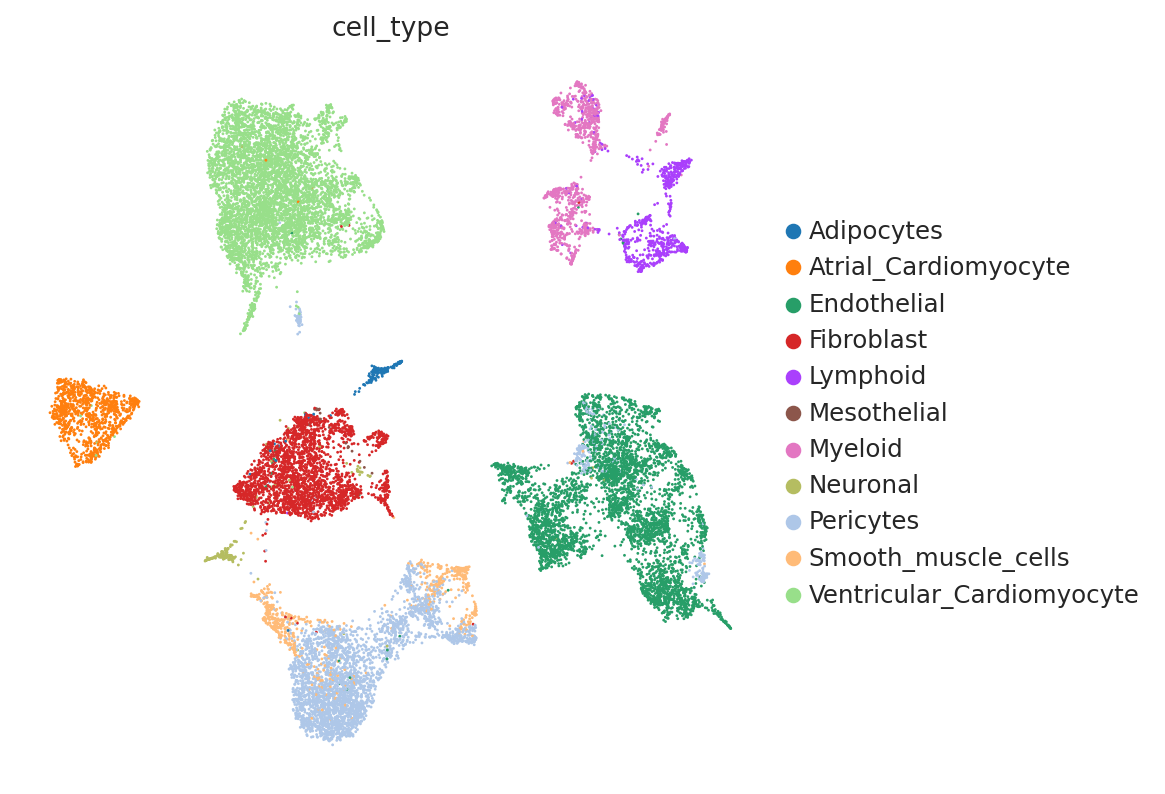

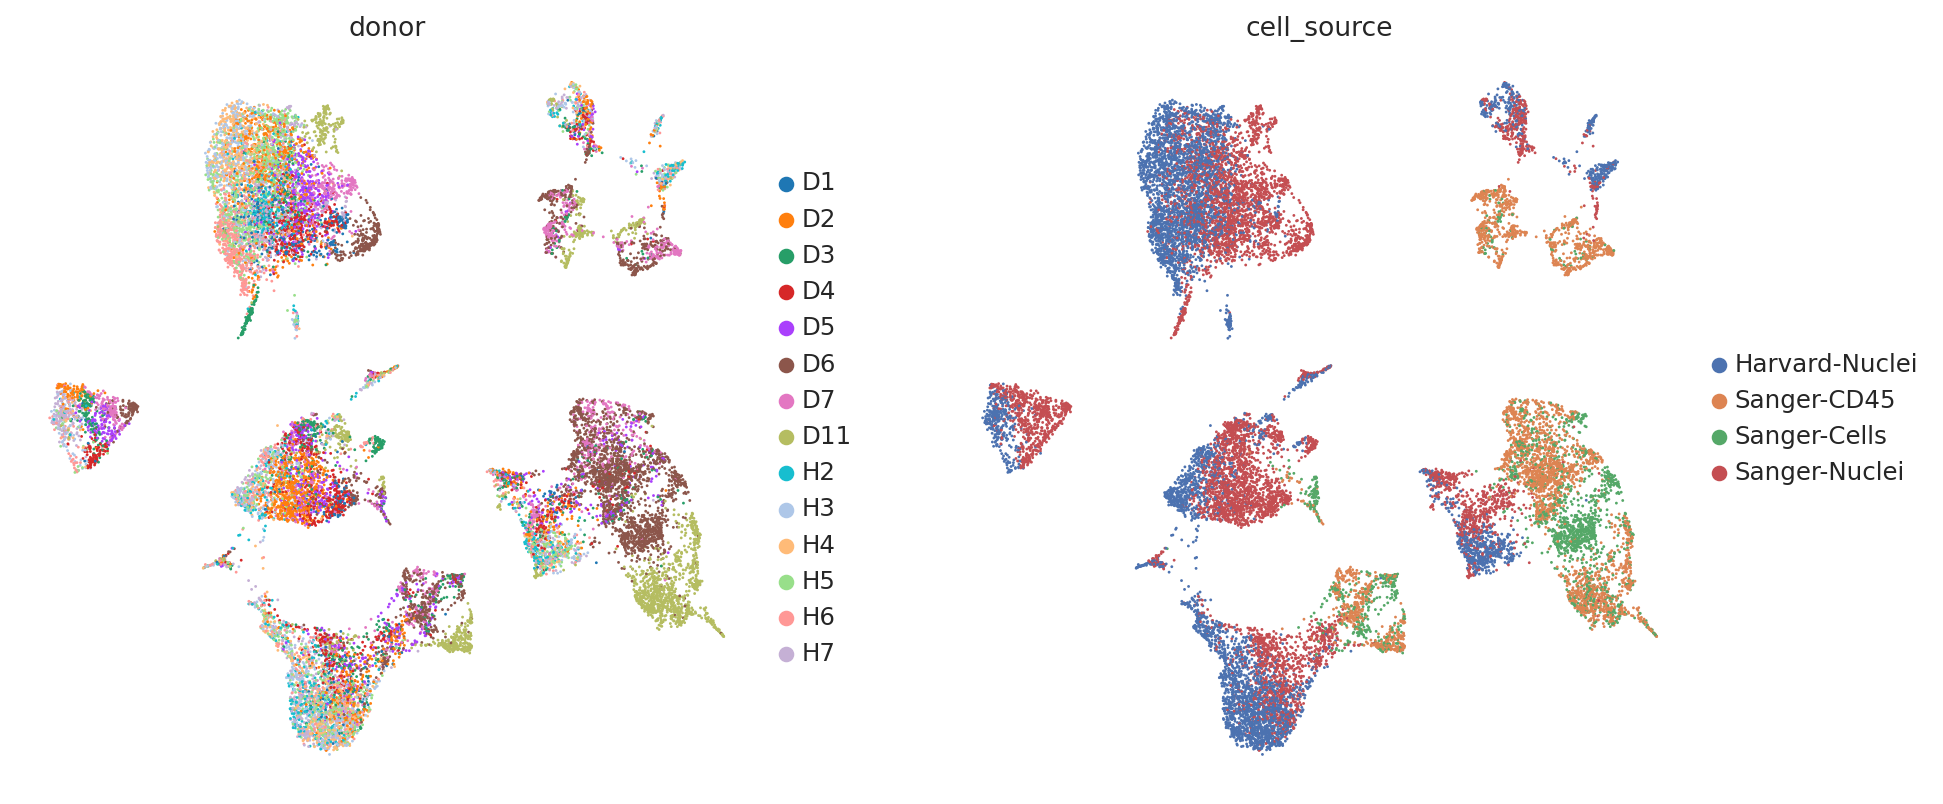

In [19]:
sc.pp.neighbors(adata, use_rep="X_scVI2")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)